In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

## Initial fitting

In [2]:
def fitting_procedure(x_data, y_data, y_uncertainties):
    """Linear least squares fitting procedure"""

    weights = 1. / y_uncertainties**2
    repeated_term = (np.sum(weights) * np.sum(x_data**2 * weights)
                     - np.sum(x_data * weights)**2)
    slope = ((np.sum(weights) * np.sum(x_data * y_data * weights)
              - np.sum(x_data * weights) * np.sum(y_data * weights))
             / repeated_term)
    slope_uncertainty = np.sqrt(np.sum(weights) / repeated_term)
    offset = ((np.sum(y_data * weights) * np.sum(x_data**2 * weights)
               - np.sum(x_data * weights) * np.sum(x_data * y_data * weights))
              / repeated_term)
    offset_uncertainty = np.sqrt(np.sum(x_data**2 * weights) / repeated_term)

    return (np.array([slope, offset]), np.array([slope_uncertainty,
                                                 offset_uncertainty]))


def linear_function(x_variable, parameters):
    """Linear model"""

    return parameters[0] * x_variable + parameters[1]

In [3]:
class SpecificRun:
    """To cleanly store all the information associated with a particular peak (needed again and again)"""

    def __init__(self, element_name, gamma_energy, file_name, line_color, exclude_height_upper, exclude_height_lower,
                 exclude_area_upper, exclude_area_lower):
        self.element_name = element_name
        self.gamma_energy = gamma_energy
        self.file_name = file_name
        self.line_color = line_color
        self.exclude_height_upper = exclude_height_upper
        self.exclude_height_lower = exclude_height_lower
        self.exclude_area_upper = exclude_area_upper
        self.exclude_area_lower = exclude_area_lower

    def set_params(self, height_params, height_param_errs, area_params, area_param_errs):
        self.height_params = height_params
        self.height_param_errs = height_param_errs
        self.area_params = area_params
        self.area_param_errs = area_param_errs

    def set_data(self, voltages_height, voltages_area, height_vals, height_errs, area_vals, area_errs):
        """The is pre-filtering of points not used in fitting (but post sorting)"""
        self.voltages_height = voltages_height
        self.voltages_area = voltages_area
        self.pulse_heights = height_vals
        self.pulse_areas = area_vals
        self.pulse_height_errs = height_errs
        self.pulse_area_errs = area_errs

    def set_data_fitted(self, voltages_height, voltages_area, height_vals, height_errs, area_vals, area_errs):
        """This is the post-filtered data to help with residual plotting"""
        self.voltages_height_fitted = voltages_height
        self.voltages_area_fitted = voltages_area
        self.pulse_heights_fitted = height_vals
        self.pulse_areas_fitted = area_vals
        self.pulse_height_errs_fitted = height_errs
        self.pulse_area_errs_fitted = area_errs

In [4]:
def plotting(voltages, height_vals, height_errs, area_vals, area_errs, run_obj):
    """Doing the log-log plot for any given source/peak for both pulse height and pulse area"""

    # Removing values that I listed as 'NA' where I couldn't find the peak
    heights_to_delete = np.isnan(height_vals)
    height_vals = np.delete(height_vals, heights_to_delete)
    height_errs = np.delete(height_errs, heights_to_delete)
    voltages_height = np.delete(voltages, heights_to_delete)

    areas_to_delete = np.isnan(area_vals)
    area_vals = np.delete(area_vals, areas_to_delete)
    area_errs = np.delete(area_errs, areas_to_delete)
    voltages_area = np.delete(voltages, areas_to_delete)

    # Sorting the values to plot and slice better
    height_vals = np.array([x for _, x in sorted(zip(voltages_height, height_vals))])
    height_errs = np.array([x for _, x in sorted(zip(voltages_height, height_errs))])
    area_vals = np.array([x for _, x in sorted(zip(voltages_area, area_vals))])
    area_errs = np.array([x for _, x in sorted(zip(voltages_area, area_errs))])
    voltages_height = np.array(sorted(voltages_height))
    voltages_area = np.array(sorted(voltages_area))

    # Adding these sorted quantities to the source/peak object
    run_obj.set_data(voltages_height, voltages_area, height_vals, height_errs, area_vals, area_errs)

    # Initial Scatter - log-log done manually
    ax1.errorbar(np.log(voltages_height), np.log(height_vals), yerr=height_errs/height_vals, fmt='x', color=run_obj.line_color)
    ax2.errorbar(np.log(voltages_area), np.log(area_vals), yerr=area_errs / area_vals, fmt='x', color=run_obj.line_color)

    # Removing the points I decided we didn't need in the fit (saturation reasons)
    voltages_height = voltages_height[run_obj.exclude_height_lower:len(voltages_height) - run_obj.exclude_height_upper]
    height_vals = height_vals[run_obj.exclude_height_lower:len(height_vals)-run_obj.exclude_height_upper]
    height_errs = height_errs[run_obj.exclude_height_lower:len(height_errs)-run_obj.exclude_height_upper]
    voltages_area = voltages_area[run_obj.exclude_area_lower:len(voltages_area) - run_obj.exclude_area_upper]
    area_vals = area_vals[run_obj.exclude_area_lower:len(area_vals)-run_obj.exclude_area_upper]
    area_errs = area_errs[run_obj.exclude_area_lower:len(area_errs)-run_obj.exclude_area_upper]

    # Adding these filtered quantities to the source/peak object (separately to the full sorted ones above)
    run_obj.set_data_fitted(voltages_height, voltages_area, height_vals, height_errs, area_vals, area_errs)

    # Doing the whole lst-sq fit and plotting it over the full range of data (no extrapolation atm)
    params_height, param_errs_height = fitting_procedure(np.log(voltages_height), np.log(height_vals), height_errs / height_vals)
    params_area, param_errs_area = fitting_procedure(np.log(voltages_area), np.log(area_vals), area_errs / area_vals)

    log_voltage_range = np.linspace(min(np.log(voltages_height)), max(np.log(voltages_height)), 100)
    ax1.plot(log_voltage_range, linear_function(log_voltage_range, params_height), color=run_obj.line_color)
    log_voltage_range = np.linspace(min(np.log(voltages_area)), max(np.log(voltages_area)), 100)
    ax2.plot(log_voltage_range, linear_function(log_voltage_range, params_area), color=run_obj.line_color)

    # Adding in the legend handles manually
    point_height = mlines.Line2D([], [], color=run_obj.line_color, marker='o', linestyle='None', markersize=5,
                                 label=f'{run_obj.element_name} - {run_obj.gamma_energy} keV: '
                                       f'm = {params_height[0]:.2f} ± {param_errs_height[0]:.4f}')
    legend_height_handles.append(point_height)
    point_area = mlines.Line2D([], [], color=run_obj.line_color, marker='o', linestyle='None', markersize=5,
                               label=f'{run_obj.element_name} - {run_obj.gamma_energy} keV: '
                                     f'm = {params_area[0]:.2f} ± {param_errs_area[0]:.4f}')
    legend_area_handles.append(point_area)

    # Adding the best-fit params and their errors to the source/peak object
    run_obj.set_params(params_height, param_errs_height, params_area, param_errs_area)

Plotting the pulse heights and pulse areas for the data from channel 1

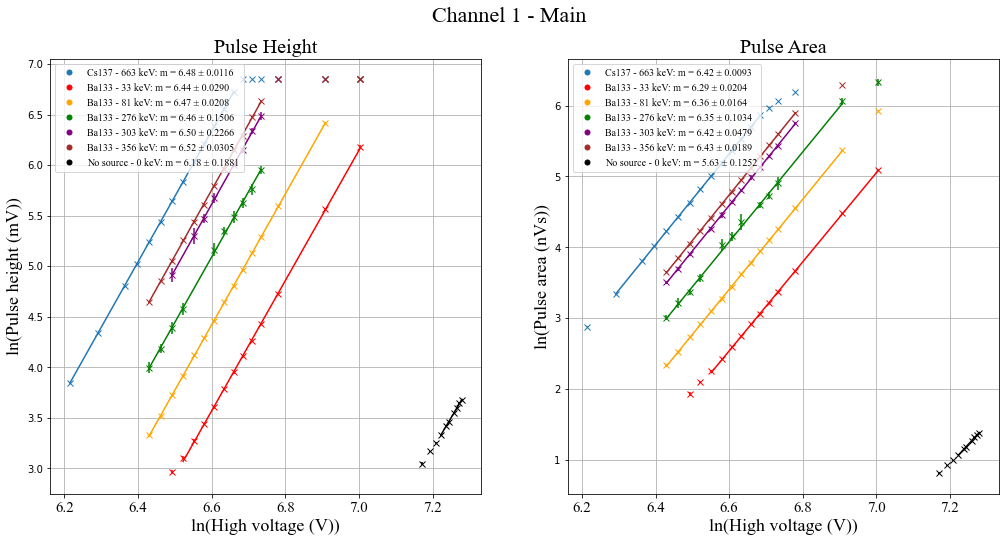

In [5]:
figure = plt.figure(figsize=(17, 8), facecolor='white')
figure.suptitle(f"Channel 1 - Main", fontsize=22, fontname='Times new Roman', y=0.97)

ax1 = figure.add_subplot(121)
ax1.set_title(f'Pulse Height', fontsize=20, fontname='Times new Roman')
ax1.set_xlabel('ln(High voltage (V))', fontsize=18, fontname='Times new Roman')
ax1.set_ylabel('ln(Pulse height (mV))', fontsize=18, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)

ax2 = figure.add_subplot(122)
ax2.set_title(f'Pulse Area', fontsize=20, fontname='Times new Roman')
ax2.set_xlabel('ln(High voltage (V))', fontsize=18, fontname='Times new Roman')
ax2.set_ylabel('ln(Pulse area (nVs))', fontsize=18, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)

# Defining the peaks to run through (excel data) and points to exclude
# Excluding of the form : height upper, height lower, area upper, area lower
cs137_1 = SpecificRun('Cs137', '663', 'Cs137.csv', '#1f77b4', 4, 0, 3, 1)
ba133_1 = SpecificRun('Ba133', '33', 'Ba133_1.csv', 'red', 0, 1, 0, 2)
ba133_2 = SpecificRun('Ba133', '81', 'Ba133_2.csv', 'orange', 1, 0, 1, 0)
ba133_3 = SpecificRun('Ba133', '276', 'Ba133_3.csv', 'green', 2, 0, 1, 0)
ba133_4 = SpecificRun('Ba133', '303', 'Ba133_4.csv', 'purple', 3, 0, 0, 0)
ba133_5 = SpecificRun('Ba133', '356', 'Ba133_5.csv', 'brown', 3, 0, 1, 0)
no_source = SpecificRun('No source', '0', 'No_source.csv', 'black', 0, 3, 0, 3)
all_runs_ch1 = [cs137_1, ba133_1, ba133_2, ba133_3, ba133_4, ba133_5, no_source]

# To store the legend data when the plotting function is called and run though
legend_height_handles = []
legend_area_handles = []

# Doing the plotting for every source
for run in all_runs_ch1:
    all_data = np.genfromtxt(f'channel_1/{run.file_name}', delimiter=',', skip_header=1)

    high_voltages = all_data[:, 0]
    pulse_heights = all_data[:, 1]
    pulse_areas = all_data[:, 3]

    # Errors tripled to account for 'human' fitting effect and other detector errors unaccounted for
    pulse_height_errs = all_data[:, 2] * 3
    pulse_area_errs = all_data[:, 4] * 3

    # Manual offset to account for low-end saturation
    if run.element_name == 'No source':
        pulse_areas += 0.7
    else:
        pulse_areas += 2.7

    plotting(high_voltages, pulse_heights, pulse_height_errs, pulse_areas, pulse_area_errs, run)

ax1.legend(handles=legend_height_handles, fontsize=18, prop={'family': 'Times New Roman'}, loc='upper left')
ax2.legend(handles=legend_area_handles, fontsize=18, prop={'family': 'Times New Roman'}, loc='upper left')

plt.show()

Not sure how to get the axes to do a 'proper' log-log plot but it works

Doing the same thing for channel 2. Didn't do the peak finding for all peaks or for all datapoints to save time.

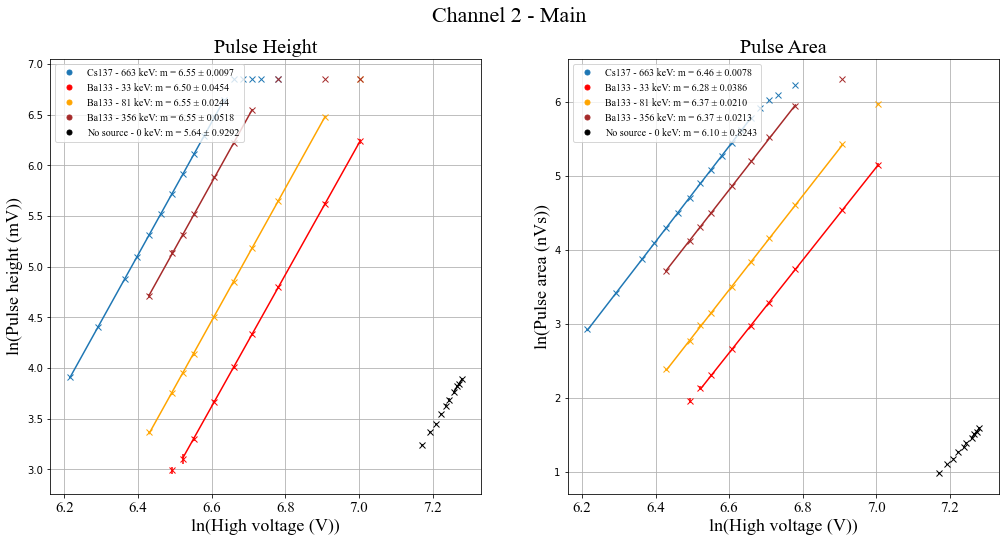

In [6]:
figure = plt.figure(figsize=(17, 8), facecolor='white')
figure.suptitle(f"Channel 2 - Main", fontsize=22, fontname='Times new Roman', y=0.97)

ax1 = figure.add_subplot(121)
ax1.set_title(f'Pulse Height', fontsize=20, fontname='Times new Roman')
ax1.set_xlabel('ln(High voltage (V))', fontsize=18, fontname='Times new Roman')
ax1.set_ylabel('ln(Pulse height (mV))', fontsize=18, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)

ax2 = figure.add_subplot(122)
ax2.set_title(f'Pulse Area', fontsize=20, fontname='Times new Roman')
ax2.set_xlabel('ln(High voltage (V))', fontsize=18, fontname='Times new Roman')
ax2.set_ylabel('ln(Pulse area (nVs))', fontsize=18, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)

# Defining the peaks to run through (excel data) and points to exclude
# Excluding of the form : height upper, height lower, area upper, area lower
cs137_1 = SpecificRun('Cs137', '663', 'Cs137.csv', '#1f77b4', 5, 0, 4, 0)
ba133_1 = SpecificRun('Ba133', '33', 'Ba133_1.csv', 'red', 0, 1, 0, 1)
ba133_2 = SpecificRun('Ba133', '81', 'Ba133_2.csv', 'orange', 1, 0, 1, 0)
ba133_5 = SpecificRun('Ba133', '356', 'Ba133_5.csv', 'brown', 3, 0, 1, 0)
no_source = SpecificRun('No source', '0', 'No_source.csv', 'black', 0, 6, 0, 6)
all_runs_ch2 = [cs137_1, ba133_1, ba133_2, ba133_5, no_source]

# To store the legend data when the plotting function is called and run though
legend_height_handles = []
legend_area_handles = []

# Doing the plotting for every source
for run in all_runs_ch2:
    all_data = np.genfromtxt(f'channel_2/{run.file_name}', delimiter=',', skip_header=1)

    high_voltages = all_data[:, 0]
    pulse_heights = all_data[:, 1]
    pulse_areas = all_data[:, 3]

    # Errors tripled to account for 'human' fitting effect and other detector errors unaccounted for
    pulse_height_errs = all_data[:, 2] * 3
    pulse_area_errs = all_data[:, 4] * 3

    # Manual offset to account for low-end saturation
    if run.element_name == 'No source':
        pulse_areas += 0.7
    else:
        pulse_areas += 2.7

    plotting(high_voltages, pulse_heights, pulse_height_errs, pulse_areas, pulse_area_errs, run)

ax1.legend(handles=legend_height_handles, fontsize=18, prop={'family': 'Times New Roman'}, loc='upper left')
ax2.legend(handles=legend_area_handles, fontsize=18, prop={'family': 'Times New Roman'}, loc='upper left')

plt.show()

## Residual plots

We can look at the residual plots to see where exactly the saturation effects kick in at the upper and lower end to exclude those points

In [7]:
def residual_plot(measurement_type, all_runs, ax_list, axs):

    for index, run in enumerate(all_runs[:-1]):
        ax_coord = ax_list[index]
        ax_y = int(ax_coord[0])
        ax_x = int(ax_coord[1])
        ax = axs[ax_y, ax_x]

        ax.set_title(f'{run.element_name} - {run.gamma_energy}keV', fontsize=18, fontname='Times new Roman')

        if measurement_type == 'Height':

            residuals = np.log(run.pulse_heights) - linear_function(np.log(run.voltages_height), run.height_params)
            ax.errorbar(np.log(run.voltages_height), residuals, yerr=run.pulse_height_errs / run.pulse_heights, fmt='x',
                        color='grey')

            residuals_fitted = np.log(run.pulse_heights_fitted) - linear_function(np.log(run.voltages_height_fitted),
                                                                                  run.height_params)
            ax.errorbar(np.log(run.voltages_height_fitted), residuals_fitted, yerr=run.pulse_height_errs_fitted /
                        run.pulse_heights_fitted, fmt='x', color=run.line_color)

        elif measurement_type == 'Area':
            residuals = np.log(run.pulse_areas) - linear_function(np.log(run.voltages_area), run.area_params)
            ax.errorbar(np.log(run.voltages_area), residuals, yerr=run.pulse_area_errs / run.pulse_areas, fmt='x',
                        color='grey')

            residuals_fitted = np.log(run.pulse_areas_fitted) - linear_function(np.log(run.voltages_area_fitted),
                                                                                run.area_params)
            ax.errorbar(np.log(run.voltages_area_fitted), residuals_fitted, yerr=run.pulse_area_errs_fitted /
                        run.pulse_areas_fitted, fmt='x', color=run.line_color)

        ax.axhline(0, color=run.line_color)
        plt.xticks(fontsize=15, fontname='Times new Roman')
        plt.xticks(fontsize=15, fontname='Times new Roman')
        ax.grid(True)

    axs[2, 0].remove()
    axs[2, 1].remove()
    if '02' in ax_list:
        axs[2, 2].remove()
    axbig = fig.add_subplot(313)
    run = all_runs[-1]
    axbig.set_title(f'{run.element_name} - {run.gamma_energy}keV', fontsize=18, fontname='Times new Roman')

    if measurement_type == 'Height':

        residuals = np.log(run.pulse_heights) - linear_function(np.log(run.voltages_height), run.height_params)
        axbig.errorbar(np.log(run.voltages_height), residuals, yerr=run.pulse_height_errs / run.pulse_heights, fmt='x', color='grey')

        residuals_fitted = np.log(run.pulse_heights_fitted) - linear_function(np.log(run.voltages_height_fitted), run.height_params)
        axbig.errorbar(np.log(run.voltages_height_fitted), residuals_fitted, yerr=run.pulse_height_errs_fitted /
                       run.pulse_heights_fitted, fmt='x', color=run.line_color)

    elif measurement_type == 'Area':
        residuals = np.log(run.pulse_areas) - linear_function(np.log(run.voltages_area), run.area_params)
        axbig.errorbar(np.log(run.voltages_area), residuals, yerr=run.pulse_area_errs / run.pulse_areas, fmt='x', color='grey')

        residuals_fitted = np.log(run.pulse_areas_fitted) - linear_function(np.log(run.voltages_area_fitted), run.area_params)
        axbig.errorbar(np.log(run.voltages_area_fitted), residuals_fitted, yerr=run.pulse_area_errs_fitted /
                       run.pulse_areas_fitted, fmt='x', color=run.line_color)

    axbig.axhline(0, color=run.line_color)
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    axbig.grid(True)

    plt.show()

For channel 1

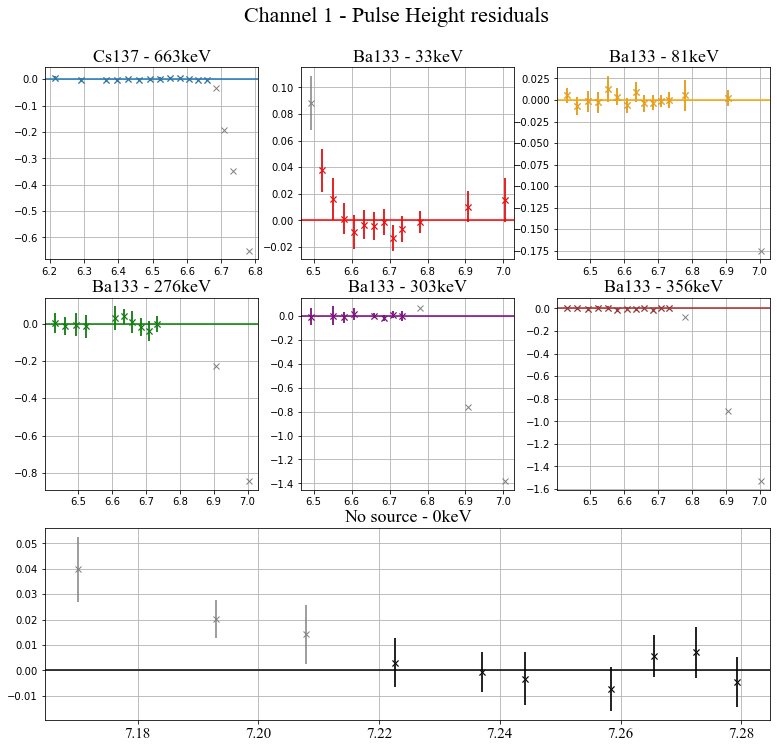

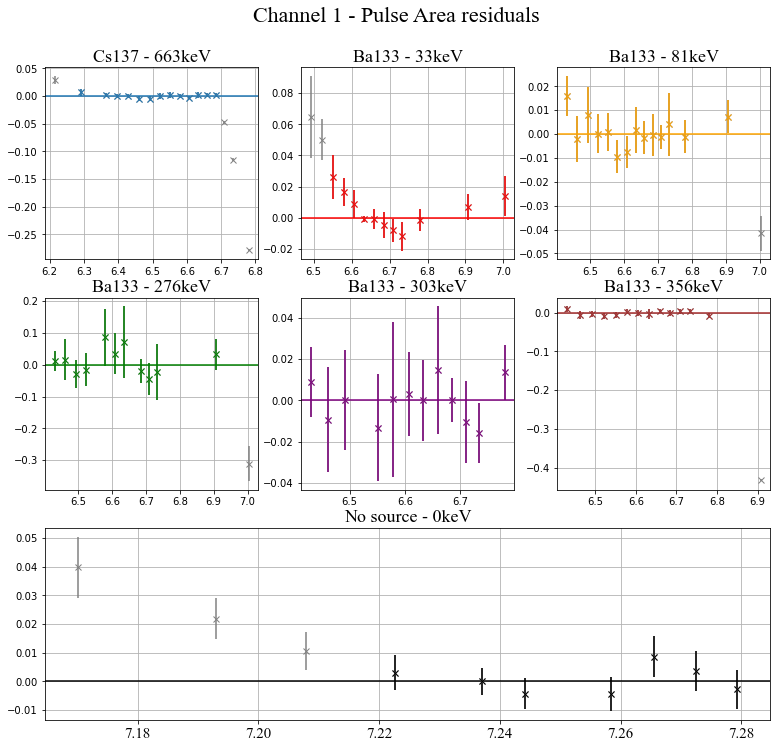

In [8]:
for measurement in ['Height', 'Area']:
    fig, axs_ch1 = plt.subplots(3, 3, figsize=(13, 12))
    fig.suptitle(f"Channel 1 - Pulse {measurement} residuals", fontsize=22, fontname='Times new Roman', y=0.95)
    ax_list_ch1 = ['00', '01', '02', '10', '11', '12']
    residual_plot(measurement, all_runs_ch1, ax_list_ch1, axs_ch1)

For channel 2

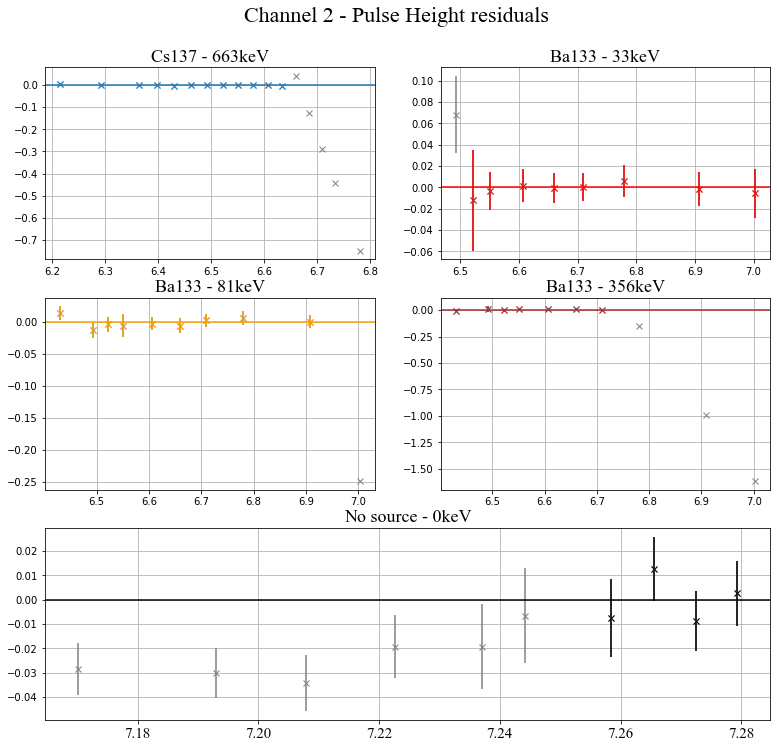

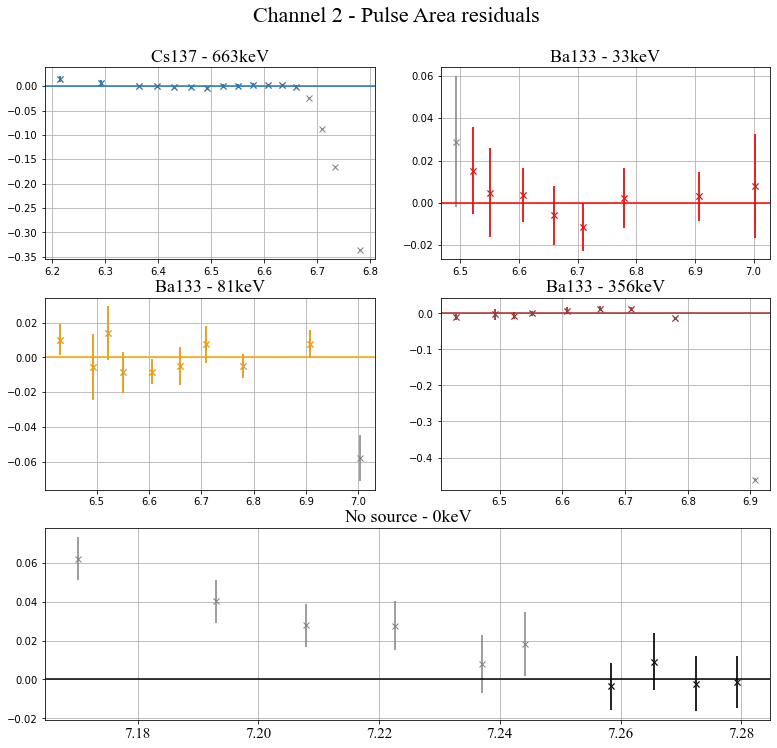

In [9]:
for measurement in ['Height', 'Area']:
    fig, axs_ch2 = plt.subplots(3, 2, figsize=(13, 12))
    fig.suptitle(f"Channel 2 - Pulse {measurement} residuals", fontsize=22, fontname='Times new Roman', y=0.95)
    ax_list_ch2 = ['00', '01', '10', '11', '20']
    residual_plot(measurement, all_runs_ch2, ax_list_ch2, axs_ch2)

# Energy Calibration with SPE

Just looking at channel 1 for now

In [10]:
height_log_voltage_range = np.linspace(6.3, 7.2, 50)
area_log_voltage_range = np.linspace(6.3, 7.4, 50)

def energy_spe_calibration(all_runs):

    height_spe_per_keV = np.empty((0, len(height_log_voltage_range)))
    area_spe_per_keV = np.empty((0, len(area_log_voltage_range)))

    for measurement_type in ['Height', 'Area']:

        if measurement_type == 'Height':
            predictions_spe = linear_function(height_log_voltage_range, all_runs[-1].height_params)
        elif measurement_type == 'Area':
            predictions_spe = linear_function(area_log_voltage_range, all_runs[-1].area_params)

        for run in all_runs[:-1]:

            if measurement_type == 'Height':
                predictions_source = linear_function(height_log_voltage_range, run.height_params)
            elif measurement_type == 'Area':
                predictions_source = linear_function(area_log_voltage_range, run.area_params)

            num_spe = np.exp(predictions_source) / np.exp(predictions_spe)
            num_spe_per_keV = num_spe / int(run.gamma_energy)

            if measurement_type == 'Height':
                height_spe_per_keV = np.vstack((height_spe_per_keV, num_spe_per_keV))
            elif measurement_type == 'Area':
                area_spe_per_keV = np.vstack((area_spe_per_keV, num_spe_per_keV))

    height_spe_per_keV_mean = np.mean(height_spe_per_keV, axis=0)
    height_spe_per_keV_err = np.std(height_spe_per_keV, axis=0)
    area_spe_per_keV_mean = np.mean(area_spe_per_keV, axis=0)
    area_spe_per_keV_err = np.std(area_spe_per_keV, axis=0)

    return height_spe_per_keV_mean, height_spe_per_keV_err, area_spe_per_keV_mean, area_spe_per_keV_err

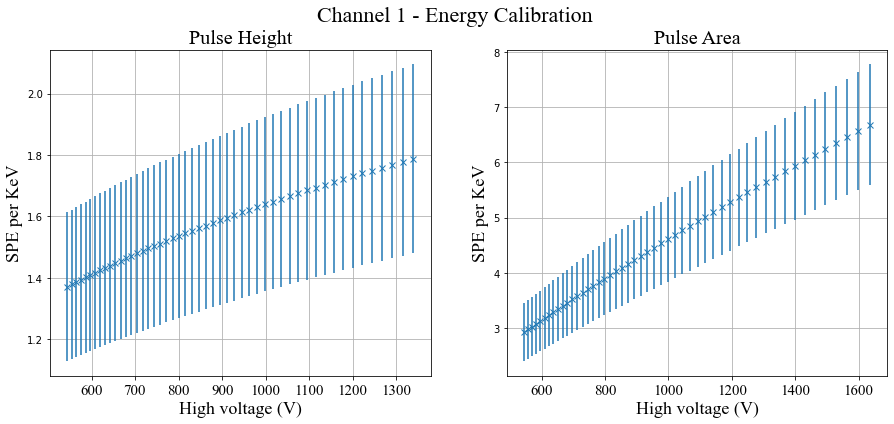

In [11]:
figure = plt.figure(figsize=(15, 6))
figure.suptitle("Channel 1 - Energy Calibration", fontsize=22, fontname='Times new Roman')

height_spe_per_keV_mean_ch1, height_spe_per_keV_err_ch1, area_spe_per_keV_mean_ch1, area_spe_per_keV_err_ch1 = \
    energy_spe_calibration(all_runs_ch1)

ax1 = figure.add_subplot(121)
ax1.set_title(f'Pulse Height', fontsize=20, fontname='Times new Roman')
ax1.set_xlabel('High voltage (V)', fontsize=18, fontname='Times new Roman')
ax1.set_ylabel('SPE per KeV', fontsize=18, fontname='Times new Roman')
ax1.errorbar(np.exp(height_log_voltage_range), height_spe_per_keV_mean_ch1, yerr=height_spe_per_keV_err_ch1, fmt='x')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)

ax2 = figure.add_subplot(122)
ax2.set_title(f'Pulse Area', fontsize=20, fontname='Times new Roman')
ax2.set_xlabel('High voltage (V)', fontsize=18, fontname='Times new Roman')
ax2.set_ylabel('SPE per KeV', fontsize=18, fontname='Times new Roman')
ax2.errorbar(np.exp(area_log_voltage_range), area_spe_per_keV_mean_ch1, yerr=area_spe_per_keV_err_ch1, fmt='x')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)

plt.show()

# Collapsing lines into one line (ignoring spe)

Try to plot pulse height/area against keV to see if the lines collapse onto one line (like they should) - only include points used in the fit?

In [12]:
def collapsing_lines_all(all_runs, channel_no):

    figure = plt.figure(figsize=(15, 6))
    figure.suptitle(f"Channel {channel_no} - Gamma energy normalisation (all)", fontsize=22, fontname='Times new Roman', y=1.01)

    ax1 = figure.add_subplot(121)
    ax1.set_title(f'Pulse Height', fontsize=20, fontname='Times new Roman')
    ax1.set_xlabel('ln(High voltage (V))', fontsize=18, fontname='Times new Roman')
    ax1.set_ylabel('ln(Pulse height/gamma energy (mV/keV))', fontsize=18, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.grid(True)

    ax2 = figure.add_subplot(122)
    ax2.set_title(f'Pulse Area', fontsize=20, fontname='Times new Roman')
    ax2.set_xlabel('ln(High voltage (V))', fontsize=18, fontname='Times new Roman')
    ax2.set_ylabel('ln(Pulse area/gamma energy (nVs/keV))', fontsize=18, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.grid(True)

    legend_height_handles = []
    legend_area_handles = []

    for run in all_runs[:-1]:
        heights_per_keV = run.pulse_heights / int(run.gamma_energy)
        height_errs_per_keV = run.pulse_height_errs / int(run.gamma_energy)
        ax1.errorbar(np.log(run.voltages_height), np.log(heights_per_keV), yerr=height_errs_per_keV/heights_per_keV, fmt='x',
                     color=run.line_color)

        areas_per_keV = run.pulse_areas / int(run.gamma_energy)
        area_errs_per_keV = run.pulse_area_errs / int(run.gamma_energy)
        ax2.errorbar(np.log(run.voltages_area), np.log(areas_per_keV), yerr=area_errs_per_keV/areas_per_keV, fmt='x',
                     color=run.line_color)

        point_height = mlines.Line2D([], [], color=run.line_color, marker='o', linestyle='None', markersize=5,
                                     label=f'{run.element_name} - {run.gamma_energy} keV')
        legend_height_handles.append(point_height)
        point_area = mlines.Line2D([], [], color=run.line_color, marker='o', linestyle='None', markersize=5,
                                   label=f'{run.element_name} - {run.gamma_energy} keV')
        legend_area_handles.append(point_area)

    ax1.legend(handles=legend_height_handles, fontsize=18, prop={'family': 'Times New Roman'}, loc='upper left')
    ax2.legend(handles=legend_area_handles, fontsize=18, prop={'family': 'Times New Roman'}, loc='upper left')

    plt.show()

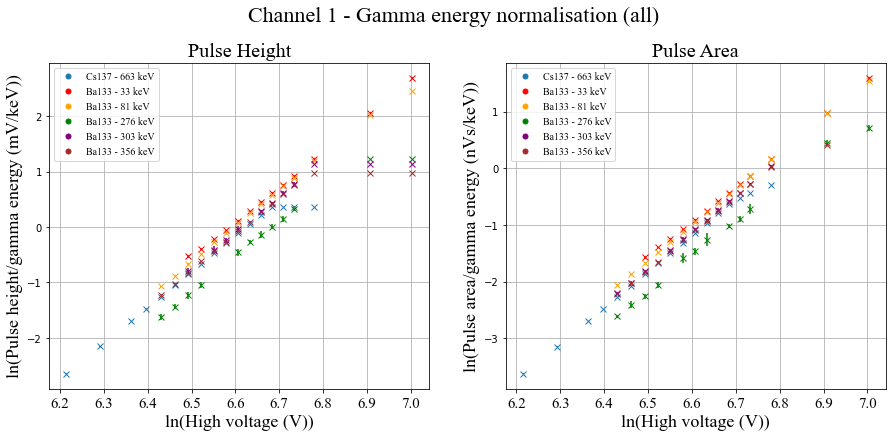

In [13]:
collapsing_lines_all(all_runs_ch1, channel_no=1)

From this Ba-133 267 keV peak seems to be a problem, this makes sense since it was the hardest to fit initially. We can see what happends if we ignore it.
We also ignore points beyond saturation limits.

In [14]:
def collapsing_lines_fitted(all_runs, channel_no):

    figure = plt.figure(figsize=(15, 6))
    figure.suptitle(f"Channel {channel_no}] - Gamma energy normalisation (fitted)", fontsize=22, fontname='Times new Roman', y=1.01)

    ax1 = figure.add_subplot(121)
    ax1.set_title(f'Pulse Height', fontsize=20, fontname='Times new Roman')
    ax1.set_xlabel('ln(High voltage (V))', fontsize=18, fontname='Times new Roman')
    ax1.set_ylabel('ln(Pulse height/gamma energy (mV/keV))', fontsize=18, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.grid(True)

    ax2 = figure.add_subplot(122)
    ax2.set_title(f'Pulse Area', fontsize=20, fontname='Times new Roman')
    ax2.set_xlabel('ln(High voltage (V))', fontsize=18, fontname='Times new Roman')
    ax2.set_ylabel('ln(Pulse area/gamma energy (nVs/keV))', fontsize=18, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.grid(True)

    legend_height_handles = []
    legend_area_handles = []

    all_heights_per_keV = np.array([])
    all_height_errs_per_keV = np.array([])
    all_height_voltages = np.array([])
    all_areas_per_keV = np.array([])
    all_area_errs_per_keV = np.array([])
    all_area_voltages = np.array([])

    for run in all_runs[:-1]:
        heights_per_keV = run.pulse_heights_fitted / int(run.gamma_energy)
        height_errs_per_keV = run.pulse_height_errs_fitted / int(run.gamma_energy)
        ax1.errorbar(np.log(run.voltages_height_fitted), np.log(heights_per_keV), yerr=height_errs_per_keV/heights_per_keV, fmt='x',
                     color=run.line_color)

        all_heights_per_keV = np.append(all_heights_per_keV, heights_per_keV)
        all_height_errs_per_keV = np.append(all_height_errs_per_keV, height_errs_per_keV)
        all_height_voltages = np.append(all_height_voltages, run.voltages_height_fitted)

        areas_per_keV = run.pulse_areas_fitted / int(run.gamma_energy)
        area_errs_per_keV = run.pulse_area_errs_fitted / int(run.gamma_energy)
        ax2.errorbar(np.log(run.voltages_area_fitted), np.log(areas_per_keV), yerr=area_errs_per_keV/areas_per_keV, fmt='x',
                     color=run.line_color)

        all_areas_per_keV = np.append(all_areas_per_keV, areas_per_keV)
        all_area_errs_per_keV = np.append(all_area_errs_per_keV, area_errs_per_keV)
        all_area_voltages = np.append(all_area_voltages, run.voltages_area_fitted)

        point_height = mlines.Line2D([], [], color=run.line_color, marker='o', linestyle='None', markersize=5,
                                     label=f'{run.element_name} - {run.gamma_energy} keV')
        legend_height_handles.append(point_height)
        point_area = mlines.Line2D([], [], color=run.line_color, marker='o', linestyle='None', markersize=5,
                                   label=f'{run.element_name} - {run.gamma_energy} keV')
        legend_area_handles.append(point_area)

    params_height, param_errs_height = fitting_procedure(np.log(all_height_voltages), np.log(all_heights_per_keV),
                                                         all_height_errs_per_keV / all_heights_per_keV)
    params_area, param_errs_area = fitting_procedure(np.log(all_area_voltages), np.log(all_areas_per_keV),
                                                     all_area_errs_per_keV / all_areas_per_keV)

    log_voltage_range_height = np.linspace(6.2, 7.3, 100)
    log_voltage_range_area = np.linspace(6.2, 7.3, 100)

    # log_voltage_range_height = np.linspace(min(np.log(all_height_voltages)), max(np.log(all_height_voltages)), 100)
    ax1.plot(log_voltage_range_height, linear_function(log_voltage_range_height, params_height), color='black')
    # log_voltage_range_area = np.linspace(min(np.log(all_area_voltages)), max(np.log(all_area_voltages)), 100)
    ax2.plot(log_voltage_range_area, linear_function(log_voltage_range_area, params_area), color='black')

    run = all_runs[-1]

    ax1.errorbar(np.log(run.voltages_height_fitted), np.log(run.pulse_heights_fitted),
                 yerr=run.pulse_height_errs_fitted/run.pulse_heights_fitted, fmt='x', color=run.line_color)
    # log_voltage_range_height = np.linspace(min(np.log(run.voltages_height_fitted)), max(np.log(run.voltages_height_fitted)), 100)
    ax1.plot(log_voltage_range_height, linear_function(log_voltage_range_height, run.height_params), color='black')

    ax2.errorbar(np.log(run.voltages_area_fitted), np.log(run.pulse_areas_fitted),
                 yerr=run.pulse_area_errs_fitted/run.pulse_areas_fitted, fmt='x', color=run.line_color)
    # log_voltage_range_area = np.linspace(min(np.log(run.voltages_area_fitted)), max(np.log(run.voltages_area_fitted)), 100)
    ax2.plot(log_voltage_range_area, linear_function(log_voltage_range_area, run.area_params), color='black')

    ax1.legend(handles=legend_height_handles, fontsize=18, prop={'family': 'Times New Roman'}, loc='upper left')
    ax2.legend(handles=legend_area_handles, fontsize=18, prop={'family': 'Times New Roman'}, loc='upper left')

    plt.show()

    print("Sources")
    print("\tHeight params:")
    print(f"\t\tgradient = {params_height[0]} ± {param_errs_height[0]}")
    print(f"\t\tintercept = {params_height[1]} ± {param_errs_height[1]}")
    print("\tArea params:")
    print(f"\t\tgradient = {params_area[0]} ± {param_errs_area[0]}")
    print(f"\t\tintercept = {params_area[1]} ± {param_errs_area[1]}")

    print("\nSPE")
    print("\tHeight params:")
    print(f"\t\tgradient = {run.height_params[0]} ± {run.height_param_errs[0]}")
    print(f"\t\tintercept = {run.height_params[1]} ± {run.height_param_errs[1]}")
    print("\tArea params:")
    print(f"\t\tgradient = {run.area_params[0]} ± {run.area_param_errs[0]}")
    print(f"\t\tintercept = {run.area_params[1]} ± {run.area_param_errs[1]}")

    return params_height, param_errs_height, params_area, param_errs_area

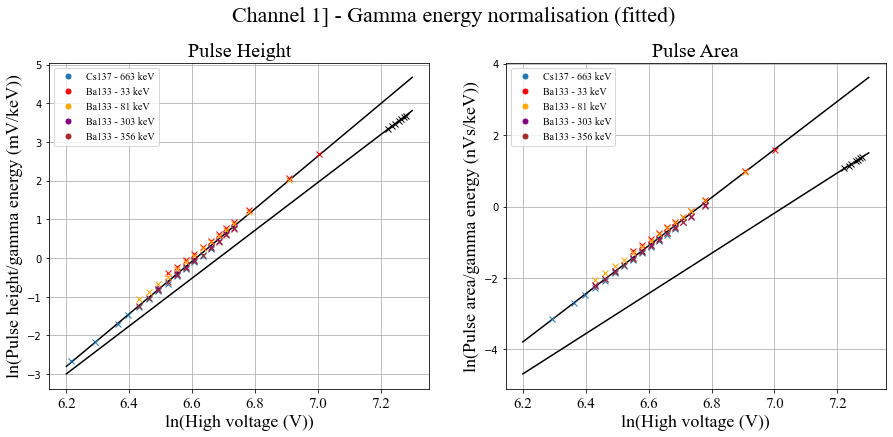

Sources
	Height params:
		gradient = 6.790380166603579 ± 0.007844565136542157
		intercept = -44.89956056446915 ± 0.051502052636572045
	Area params:
		gradient = 6.732157045908539 ± 0.006068409375301353
		intercept = -45.5284856727503 ± 0.040008789667991304

SPE
	Height params:
		gradient = 6.184817352219108 ± 0.18809754709184337
		intercept = -41.33930331906455 ± 1.3643799302565036
	Area params:
		gradient = 5.6258104001988105 ± 0.12522139895191886
		intercept = -39.56535099219113 ± 0.9079549435520989


In [15]:
params_height_collapsed_ch1, param_errs_height_collapsed_ch1, params_area_collapsed_ch1, param_errs_area_collapsed_ch1 = \
    collapsing_lines_fitted(all_runs_ch1[:3]+all_runs_ch1[4:], channel_no=1)

Quick test with one point LYSO calibration (note that I havn't done the manual offset correction)

In [16]:
def quick_lyso_test(lyso_voltage, lyso_heights, lyso_areas, params_height_collapsed, params_area_collapsed):

    lyso_areas += 2.7

    height_per_keV_predict = linear_function(np.log(lyso_voltage), params_height_collapsed)
    area_per_keV_predict = linear_function(np.log(lyso_voltage), params_area_collapsed)

    lyso_height_gammas = lyso_heights / np.exp(height_per_keV_predict)
    lyso_area_gammas = lyso_areas / np.exp(area_per_keV_predict)

    print(lyso_height_gammas)
    print(lyso_area_gammas)

In [17]:
quick_lyso_test(740, np.array([68.2, 191.6, 287.7]), np.array([22.39, 67.58, 101.6]), params_height_collapsed_ch1,
                params_area_collapsed_ch1)

[ 70.8339735  198.99984343 298.81135154]
[ 71.8045922  201.13299083 298.49417962]


In [18]:
quick_lyso_test(620, np.array([23.28, 62.9, 91.08]), np.array([6.071, 20.42, 30.57]), params_height_collapsed_ch1,
                params_area_collapsed_ch1)

[ 80.3920722  217.21053872 314.52362267]
[ 82.60376086 217.74016087 313.33110519]


In [19]:
quick_lyso_test(840, np.array([152.2, 441.1, 662.8]), np.array([51.61, 156.4, 234]), params_height_collapsed_ch1,
                params_area_collapsed_ch1)

[ 66.84639329 193.73156426 291.10242754]
[ 66.2128833  193.96924567 288.5764956 ]


True values should be at 55, 202 & 307 keV

If we take the pulse / keV ratio with this new collapsed line and one SPE point (should give no. spe per keV)

In [20]:
def finding_num_spe_per_kev(spe_run, params_height_collapsed, param_errs_height_collapsed, params_area_collapsed,
                            param_errs_area_collapsed):

    spe_point_voltage_height = spe_run.voltages_height_fitted[-1]
    spe_point_pulse_height = spe_run.pulse_heights_fitted[-1]
    spe_point_pulse_height_err = spe_run.pulse_height_errs_fitted[-1]

    spe_point_voltage_area = spe_run.voltages_area_fitted[-1]
    spe_point_pulse_area = spe_run.pulse_areas_fitted[-1]
    spe_point_pulse_area_err = spe_run.pulse_area_errs_fitted[-1]

    collapsed_line_prediction_height = linear_function(np.log(spe_point_voltage_height), params_height_collapsed)
    collapsed_line_prediction_height_err = np.sqrt(np.log(spe_point_voltage_height)**2 * param_errs_height_collapsed[0]**2 +
                                                   param_errs_height_collapsed[1]**2)

    collapsed_line_prediction_area = linear_function(np.log(spe_point_voltage_area), params_area_collapsed)
    collapsed_line_prediction_area_err = np.sqrt(np.log(spe_point_voltage_height)**2 * param_errs_area_collapsed[0]**2 +
                                                 param_errs_area_collapsed[1]**2)

    num_spe_per_keV_height = np.exp(collapsed_line_prediction_height) / spe_point_pulse_height
    num_spe_per_keV_height_err = num_spe_per_keV_height * np.sqrt( collapsed_line_prediction_height_err**2 +
                                                                   (spe_point_pulse_height_err/spe_point_pulse_height)**2 )

    num_spe_per_keV_area = np.exp(collapsed_line_prediction_area) / spe_point_pulse_area
    num_spe_per_keV_area_err = num_spe_per_keV_area * np.sqrt( collapsed_line_prediction_area_err**2 +
                                                               (spe_point_pulse_area_err/spe_point_pulse_area)**2 )

    print(f"Pulse Height : {num_spe_per_keV_height} ± {num_spe_per_keV_height_err} number of spe per keV")
    print(f"Pulse Area : {num_spe_per_keV_area} ± {num_spe_per_keV_area_err} number of spe per keV")

    return num_spe_per_keV_height, num_spe_per_keV_height_err, num_spe_per_keV_area, num_spe_per_keV_area_err

In [21]:
num_spe_per_keV_height_ch1, num_spe_per_keV_height_err_ch1, num_spe_per_keV_area_ch1, num_spe_per_keV_area_err_ch1 = \
    finding_num_spe_per_kev(all_runs_ch1[-1], params_height_collapsed_ch1, param_errs_height_collapsed_ch1, params_area_collapsed_ch1,
                            param_errs_area_collapsed_ch1)

Pulse Height : 2.345430258498107 ± 0.18183531991361793 number of spe per keV
Pulse Area : 8.109125953793303 ± 0.4863991199591468 number of spe per keV


We can scale the collapsed line using this number of spe per keV to look at the residuals of the SPE that we ignored initially. They should curve in asymptotically to zero (since we are fixing the last point by design) if our theory of neglecting them is correct.

In [22]:
def collapsed_line_spe_residuals(spe_run, params_height_collapsed, param_errs_height_collapsed, params_area_collapsed,
                                 param_errs_area_collapsed, num_spe_per_keV_height, num_spe_per_keV_height_err, num_spe_per_keV_area, num_spe_per_keV_area_err, channel_no):

    figure = plt.figure(figsize=(16, 5))
    figure.suptitle(f"Channel {channel_no} - SPE residuals from scaled combined fit", fontsize=22, fontname='Times new Roman', y=1.01)

    ax1 = figure.add_subplot(121)
    ax1.set_title(f'Pulse Height', fontsize=20, fontname='Times new Roman')
    ax1.set_xlabel('ln(High voltage (V))', fontsize=18, fontname='Times new Roman')
    ax1.set_ylabel('ln(Pulse height (mV))', fontsize=18, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.grid(True)

    ax2 = figure.add_subplot(122)
    ax2.set_title(f'Pulse Area', fontsize=20, fontname='Times new Roman')
    ax2.set_xlabel('ln(High voltage (V))', fontsize=18, fontname='Times new Roman')
    ax2.set_ylabel('ln(Pulse area (nVs))', fontsize=18, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.grid(True)

    new_params_height_collapsed = [params_height_collapsed[0], params_height_collapsed[1] - np.log(num_spe_per_keV_height)]
    new_param_errs_height_collapsed = [param_errs_height_collapsed[0], np.sqrt(param_errs_height_collapsed[1]**2 +
                                                                               num_spe_per_keV_height_err**2 / num_spe_per_keV_height**2)]
    log_predictions_height = linear_function(np.log(spe_run.voltages_height), new_params_height_collapsed)
    residuals_height = np.log(spe_run.pulse_heights) - log_predictions_height
    residuals_height_err = np.sqrt( spe_run.pulse_height_errs**2 / spe_run.pulse_heights**2 + np.log(spe_run.voltages_height)**2 *
                                    new_param_errs_height_collapsed[0]**2 + new_param_errs_height_collapsed[1]**2)
    ax1.errorbar(np.log(spe_run.voltages_height), residuals_height, yerr=residuals_height_err, fmt='x', color=spe_run.line_color)
    ax1.axhline(0, color='red')

    new_params_area_collapsed = [params_area_collapsed[0], params_area_collapsed[1] - np.log(num_spe_per_keV_area)]
    new_param_errs_area_collapsed = [param_errs_area_collapsed[0], np.sqrt(param_errs_area_collapsed[1]**2 +
                                                                           num_spe_per_keV_area_err**2 / num_spe_per_keV_area**2)]
    log_predictions_area = linear_function(np.log(spe_run.voltages_area), new_params_area_collapsed)
    residuals_area = np.log(spe_run.pulse_areas) - log_predictions_area
    residuals_area_err = np.sqrt( spe_run.pulse_area_errs**2 / spe_run.pulse_areas**2 + np.log(spe_run.voltages_area)**2 *
                                  new_param_errs_area_collapsed[0]**2 + new_param_errs_area_collapsed[1]**2)
    ax2.errorbar(np.log(spe_run.voltages_area), residuals_area, yerr=residuals_area_err, fmt='x',
                 color=spe_run.line_color)
    ax2.axhline(0, color='red')

    plt.show()

    # Errors include, measurement error, linear fit error, number of spe error

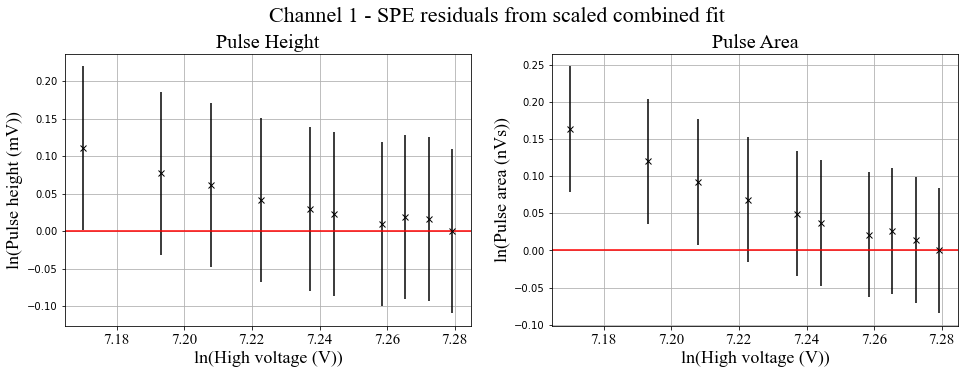

In [23]:
collapsed_line_spe_residuals(all_runs_ch1[-1], params_height_collapsed_ch1, param_errs_height_collapsed_ch1, params_area_collapsed_ch1,
                             param_errs_area_collapsed_ch1, num_spe_per_keV_height_ch1, num_spe_per_keV_height_err_ch1, num_spe_per_keV_area_ch1, num_spe_per_keV_area_err_ch1, channel_no=1)

Little aside : Trying to see how pulse height/area / keV scaled to Ba-133 33keV looks like

In [24]:
height_log_voltage_range = np.linspace(6.3, 7.2, 50)
area_log_voltage_range = np.linspace(6.3, 7.4, 50)

def energy_spe_calibration_ba133(all_runs):

    height_spe_per_keV = np.empty((0, len(height_log_voltage_range)))
    area_spe_per_keV = np.empty((0, len(area_log_voltage_range)))

    all_runs_trial = all_runs[:1] + all_runs[2:-1]

    for measurement_type in ['Height', 'Area']:

        if measurement_type == 'Height':
            predictions_ba133_33 = linear_function(height_log_voltage_range, all_runs[1].height_params)
        elif measurement_type == 'Area':
            predictions_ba133_33 = linear_function(area_log_voltage_range, all_runs[1].area_params)

        for run in all_runs_trial:

            if measurement_type == 'Height':
                predictions_source = linear_function(height_log_voltage_range, run.height_params)
            elif measurement_type == 'Area':
                predictions_source = linear_function(area_log_voltage_range, run.area_params)

            num = np.exp(predictions_source) / np.exp(predictions_ba133_33)
            # num_spe_per_keV = num_spe / int(all_runs[1].gamma_energy)

            if measurement_type == 'Height':
                height_spe_per_keV = np.vstack((height_spe_per_keV, num))
            elif measurement_type == 'Area':
                area_spe_per_keV = np.vstack((area_spe_per_keV, num))

    height_spe_per_keV_mean = np.mean(height_spe_per_keV, axis=0)
    height_spe_per_keV_err = np.std(height_spe_per_keV, axis=0)
    area_spe_per_keV_mean = np.mean(area_spe_per_keV, axis=0)
    area_spe_per_keV_err = np.std(area_spe_per_keV, axis=0)

    return height_spe_per_keV_mean, height_spe_per_keV_err, area_spe_per_keV_mean, area_spe_per_keV_err

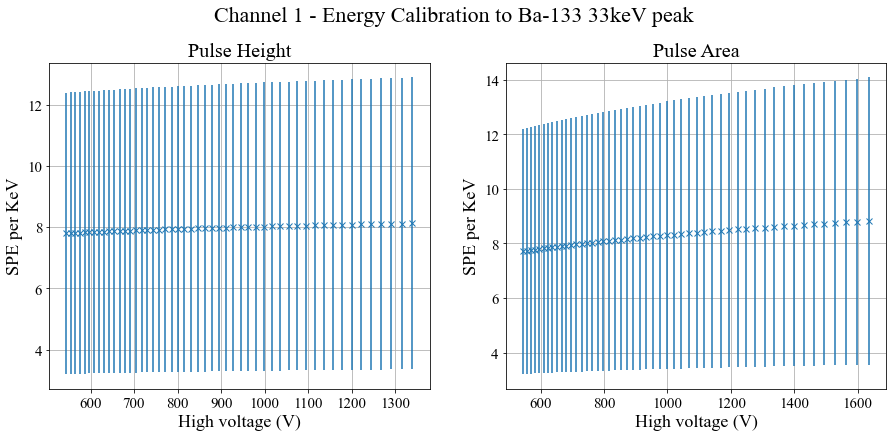

In [25]:
figure = plt.figure(figsize=(15, 6))
figure.suptitle("Channel 1 - Energy Calibration to Ba-133 33keV peak", fontsize=22, fontname='Times new Roman', y=1.01)

height_spe_per_keV_mean_ch1, height_spe_per_keV_err_ch1, area_spe_per_keV_mean_ch1, area_spe_per_keV_err_ch1 = \
    energy_spe_calibration_ba133(all_runs_ch1)

ax1 = figure.add_subplot(121)
ax1.set_title(f'Pulse Height', fontsize=20, fontname='Times new Roman')
ax1.set_xlabel('High voltage (V)', fontsize=18, fontname='Times new Roman')
ax1.set_ylabel('SPE per KeV', fontsize=18, fontname='Times new Roman')
ax1.errorbar(np.exp(height_log_voltage_range), height_spe_per_keV_mean_ch1, yerr=height_spe_per_keV_err_ch1, fmt='x')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.yticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)

ax2 = figure.add_subplot(122)
ax2.set_title(f'Pulse Area', fontsize=20, fontname='Times new Roman')
ax2.set_xlabel('High voltage (V)', fontsize=18, fontname='Times new Roman')
ax2.set_ylabel('SPE per KeV', fontsize=18, fontname='Times new Roman')
ax2.errorbar(np.exp(area_log_voltage_range), area_spe_per_keV_mean_ch1, yerr=area_spe_per_keV_err_ch1, fmt='x')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.yticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)

plt.show()

Doing the whole collapsing lines thing for channel 2 to check the number of spe per KeV result

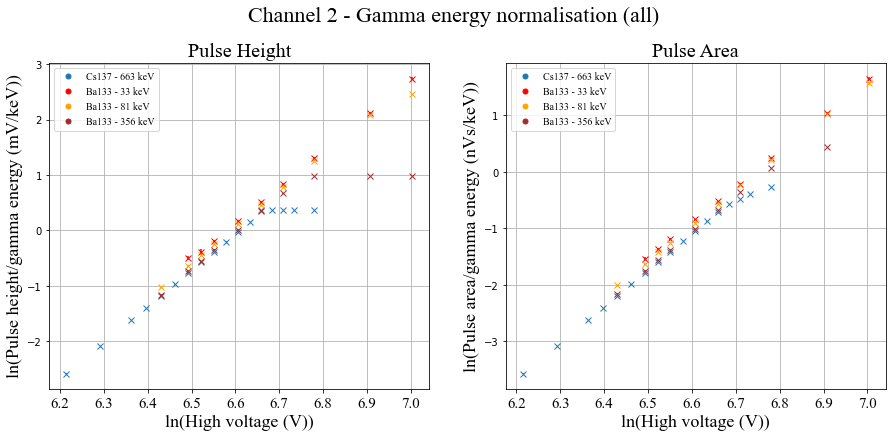

In [26]:
collapsing_lines_all(all_runs_ch2, channel_no=2)

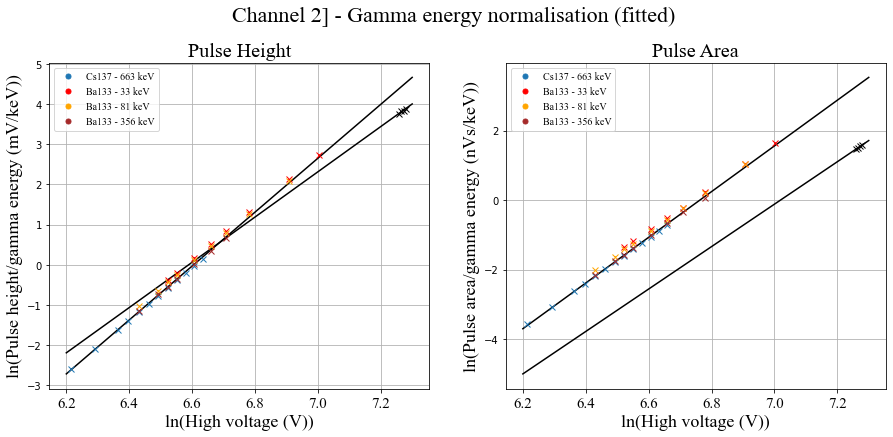

Sources
	Height params:
		gradient = 6.713949221022075 ± 0.007567490886731666
		intercept = -44.34594217753499 ± 0.04915850296212946
	Area params:
		gradient = 6.574935576775127 ± 0.00602302181443745
		intercept = -44.46847700640784 ± 0.03942351420940848

SPE
	Height params:
		gradient = 5.6351400522096124 ± 0.9292176675475884
		intercept = -37.13236341537051 ± 6.755227494767863
	Area params:
		gradient = 6.104251806991876 ± 0.8243384392953348
		intercept = -42.85015218583042 ± 5.991448234910228


In [27]:
params_height_collapsed_ch2, param_errs_height_collapsed_ch2, params_area_collapsed_ch2, param_errs_area_collapsed_ch2 = \
    collapsing_lines_fitted(all_runs_ch2, channel_no=2)

In [28]:
num_spe_per_keV_height_ch2, num_spe_per_keV_height_err_ch2, num_spe_per_keV_area_ch2, num_spe_per_keV_area_err_ch2 = \
    finding_num_spe_per_kev(all_runs_ch2[-1], params_height_collapsed_ch2, param_errs_height_collapsed_ch2, params_area_collapsed_ch2,
                            param_errs_area_collapsed_ch2)

Pulse Height : 1.890513596336786 ± 0.1418901147083856 number of spe per keV
Pulse Area : 6.106025829118132 ± 0.36940480910606455 number of spe per keV


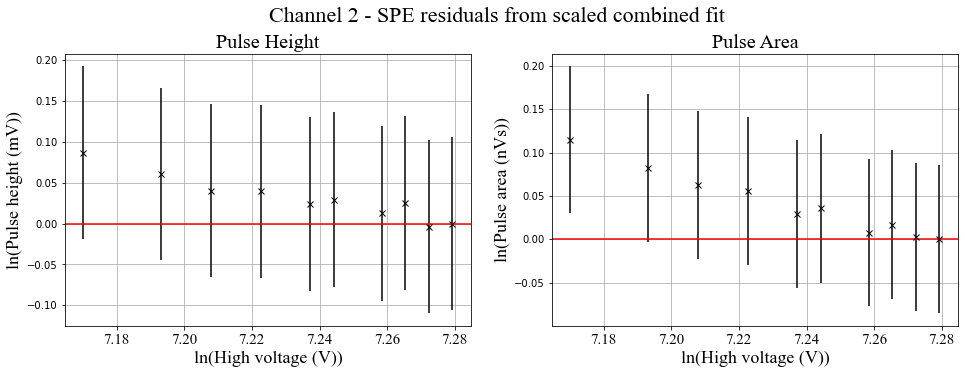

In [29]:
collapsed_line_spe_residuals(all_runs_ch2[-1], params_height_collapsed_ch2, param_errs_height_collapsed_ch2, params_area_collapsed_ch2,
                             param_errs_area_collapsed_ch2, num_spe_per_keV_height_ch2, num_spe_per_keV_height_err_ch2, num_spe_per_keV_area_ch2, num_spe_per_keV_area_err_ch2, channel_no=2)

# Exploring explicit energy dependence

Going back to channel 1 for now

Pick one voltage and plot energy against pulse height?

In [30]:
def energy_plot(all_runs, voltage):

    figure = plt.figure(figsize=(15, 6))
    figure.suptitle(f"Channel 1 - Energy variation for {voltage} V", fontsize=22, fontname='Times new Roman', y=1.01)

    ax1 = figure.add_subplot(121)
    ax1.set_title(f'Pulse Height', fontsize=20, fontname='Times new Roman')
    ax1.set_ylabel('Pulse Height (mV)', fontsize=18, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.yticks(fontsize=15, fontname='Times new Roman')
    plt.grid(True)

    ax2 = figure.add_subplot(122)
    ax2.set_title(f'Pulse Area', fontsize=20, fontname='Times new Roman')
    ax2.set_ylabel('Pulse area (nVs)', fontsize=18, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.yticks(fontsize=15, fontname='Times new Roman')
    plt.grid(True)

    energies_V = np.array([])
    pulse_heights_V = np.array([])
    pulse_height_errs_V = np.array([])
    pulse_areas_V = np.array([])
    pulse_area_errs_V = np.array([])

    for run in all_runs:
        pulse_height_V = np.exp(linear_function(np.log(voltage), run.height_params))
        pulse_height_err_V = pulse_height_V * np.sqrt(np.log(voltage)**2 * run.height_param_errs[0]**2 + run.height_param_errs[1]**2)
        ax1.errorbar(int(run.gamma_energy), pulse_height_V, yerr=pulse_height_err_V, fmt='x', color=run.line_color)

        pulse_area_V = np.exp(linear_function(np.log(voltage), run.area_params))
        pulse_area_err_V = pulse_area_V * np.sqrt(np.log(voltage)**2 * run.area_param_errs[0]**2 + run.area_param_errs[1]**2)
        ax2.errorbar(int(run.gamma_energy), pulse_area_V, yerr=pulse_area_err_V, fmt='x', color=run.line_color)

        energies_V = np.append(energies_V, int(run.gamma_energy))
        pulse_heights_V = np.append(pulse_heights_V, pulse_height_V)
        pulse_height_errs_V = np.append(pulse_height_errs_V, pulse_height_err_V)
        pulse_areas_V = np.append(pulse_areas_V, pulse_area_V)
        pulse_area_errs_V = np.append(pulse_area_errs_V, pulse_area_err_V)

    params_height, params_height_err = fitting_procedure(energies_V, pulse_heights_V, pulse_height_errs_V)
    params_area, params_area_err = fitting_procedure(energies_V, pulse_areas_V, pulse_area_errs_V)

    x = np.linspace(0, 663, 100)
    ax1.plot(x, linear_function(x, params_height), color='black')
    ax2.plot(x, linear_function(x, params_area), color='black')

    plt.show()

    figure = plt.figure(figsize=(15, 3))

    ax1 = figure.add_subplot(121)
    ax1.set_xlabel('Gamma energy (keV)', fontsize=18, fontname='Times new Roman')
    ax1.set_ylabel('Residuals (mV)', fontsize=18, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.yticks(fontsize=15, fontname='Times new Roman')
    plt.grid(True)

    ax2 = figure.add_subplot(122)
    ax2.set_title(f'Pulse Area', fontsize=20, fontname='Times new Roman')
    ax2.set_xlabel('Gamma energy (keV)', fontsize=18, fontname='Times new Roman')
    ax2.set_ylabel('Residuals (nVs)', fontsize=18, fontname='Times new Roman')
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.yticks(fontsize=15, fontname='Times new Roman')
    plt.grid(True)

    for run in all_runs:
        pulse_height_V = np.exp(linear_function(np.log(voltage), run.height_params))
        pulse_height_V_err = np.sqrt(np.log(voltage)**2 * run.height_param_errs[0]**2 + run.height_param_errs[1]**2)
        predict_height = linear_function(int(run.gamma_energy), params_height)
        predict_height_V_err = np.sqrt(int(run.gamma_energy)**2 * params_height_err[0]**2 + params_height_err[1]**2)
        residual_height = pulse_height_V - predict_height
        residual_height_err = np.sqrt(pulse_height_V_err**2 + predict_height_V_err**2)
        ax1.errorbar(int(run.gamma_energy), residual_height, yerr=residual_height_err, color=run.line_color, fmt='x')

        pulse_area_V = np.exp(linear_function(np.log(voltage), run.area_params))
        pulse_area_V_err = np.sqrt(np.log(voltage)**2 * run.area_param_errs[0]**2 + run.area_param_errs[1]**2)
        predict_area = linear_function(int(run.gamma_energy), params_area)
        predict_area_V_err = np.sqrt(int(run.gamma_energy)**2 * params_area_err[0]**2 + params_area_err[1]**2)
        residual_area = pulse_area_V - predict_area
        residual_area_err = np.sqrt(pulse_area_V_err**2 + predict_area_V_err**2)
        ax2.errorbar(int(run.gamma_energy), residual_area, yerr=residual_area_err, color=run.line_color, fmt='x')

    ax1.axhline(0, color='black')
    ax2.axhline(0, color='black')

    plt.show()

    print(params_height)
    print(params_height_err)
    print()
    print(params_area)
    print(params_area_err)

# Add legend
# Add nonlinear term

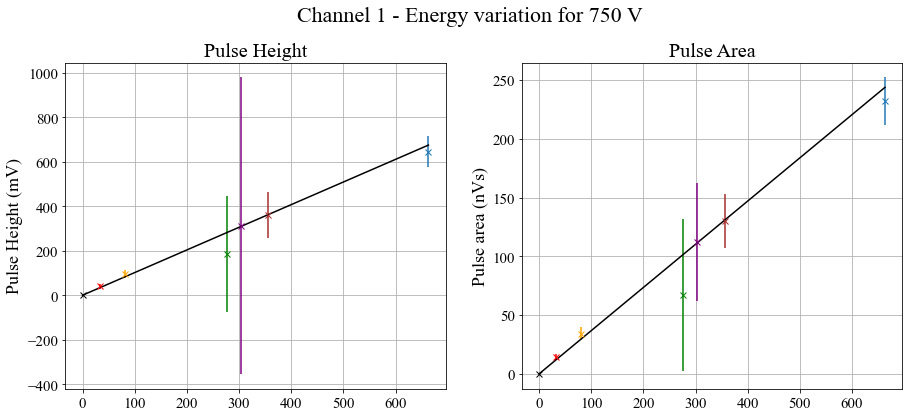

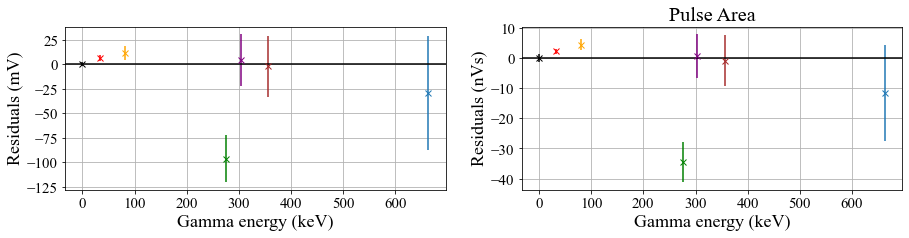

[1.01758517 0.79164227]
[0.08747178 1.23643175]

[0.36767951 0.10388505]
[0.02380474 0.12046929]


In [33]:
energy_plot(all_runs_ch1, 750)

# Post installing the detector

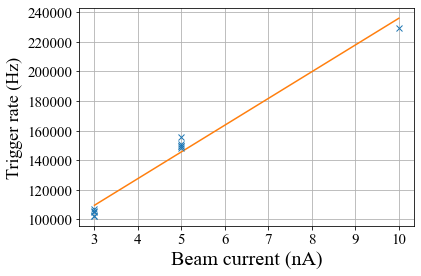

[18052.19004515 55343.45618078]
[ 3.20069301 16.81320343]


In [32]:
crocker_event_data = np.genfromtxt('crocker_beam_events.csv', delimiter=',', skip_header=1)
currents = crocker_event_data[:, 2]
rate_ch1 = crocker_event_data[:, 5]
rate_ch1_err = crocker_event_data[:, 6]
rate_ch2 = crocker_event_data[:, 7][:-1]            # no data for channel 2 at last point
rate_ch2_err = crocker_event_data[:, 8][:-1]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(currents, rate_ch1, yerr=rate_ch1_err, fmt='x')
params, errs = fitting_procedure(currents, rate_ch1, rate_ch1_err)
ax.plot(currents, linear_function(currents, params))
ax.set_xlabel(f'Beam current (nA)', fontsize=20, fontname='Times new Roman')
ax.set_ylabel('Trigger rate (Hz)', fontsize=18, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.yticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)
plt.show()

print(params)
print(errs)

Only worth plotting CH1 since there are only 2 currents for CH2 (useless to fit a line to)